In [1]:
import STAGATE
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from sklearn import metrics
from pathlib import Path

In [2]:
# adata = sc.read_h5ad('../data/MERFISH/MERFISH_0.09.h5ad')
# adata = sc.read_h5ad('../data/BaristaSeq/Slice_2_removed.h5ad')
adata = sc.read_h5ad('../data/osmfish/osmfish_remove_excluded.h5ad')
print(adata)
adata.var_names_make_unique()
n_clusters = len(adata.obs['Region'].unique())

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region'
    uns: 'ClusterName_colors'
    obsm: 'spatial'


In [3]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/data/hgh/anaconda3/envs/STAGATE/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,


------Calculating spatial graph...
The graph contains 2180 edges, 4839 cells.
0.4505 neighbors per cell on average.


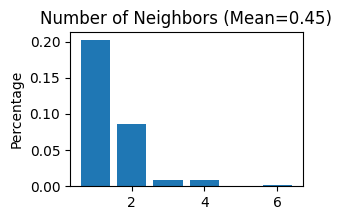

In [4]:
STAGATE.Cal_Spatial_Net(adata, rad_cutoff=150)
STAGATE.Stats_Spatial_Net(adata)

In [5]:
adata = STAGATE.train_STAGATE(adata, alpha=0)

Size of Input:  (4839, 33)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2025-04-16 21:37:48.578777: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2025-04-16 21:37:48.796098: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400000000 Hz
2025-04-16 21:37:48.816213: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555c9e786bc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-04-16 21:37:48.825917: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-04-16 21:37:48.842078: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-04-16 21:37:49.146624: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555c9e806c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-16 21:37:49.146657: I

In [6]:
adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=n_clusters)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [7]:
obs_df = adata.obs.dropna()
ARI = metrics.adjusted_rand_score(obs_df['mclust'], obs_df['Region'])
NMI = metrics.normalized_mutual_info_score(obs_df['mclust'], obs_df['Region'])
print('Adjusted rand index = %.4f' %ARI)

Adjusted rand index = 0.1227


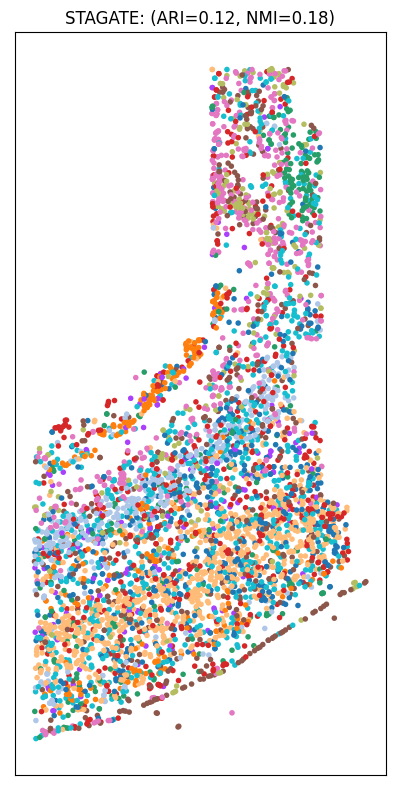

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sc.pl.spatial(adata, color='mclust', ax=ax, show=False, spot_size=20, size=20, color_map='viridis',legend_loc=None)
# sc.pl.spatial(adata, color='mclust', ax=ax, show=False, spot_size=20)
ax.set_title('STAGATE: (ARI=%.2f, NMI=%.2f)' % (ARI, NMI))
ax.set_xlabel('')
ax.set_ylabel('')
output_dir = './STAGATE_ARI_NMI'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, "STAGATE_osmfish_ARI.svg")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.tight_layout()
# output_dir = ('./STAGATE_ARI_NMI')
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# output_path = os.path.join(output_dir, "ba3.svg")
# plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

In [9]:
output_dir1 = ('../featrue/osmish')
if not os.path.exists(output_dir1):
    os.makedirs(output_dir1)
output_path = os.path.join(output_dir1, f"STAGATE.h5ad")
adata.write_h5ad(output_path)